# Introduction to Equivariant Modelling in Materials Science

Table of contents:
- [Why Equivariance?](#why-equivariance)
- [Symmetry in Materials Science](#symmetry-in-materials-science)
- [What is Equivariance?](#what-is-equivariance)
- [Equivariant Neural Networks](#equivariant-neural-networks)
- [Example: Phonon Prediction](#example-energy-prediction)

In this tutorial we will explore the basics of equivariance (with some math) and also a concrete example of using Neural Networks equipped with equivariant layers to predict the energy of a molecule. 
No mathematical background is required, we will also provide references for further reading in case you are interested.

# Why Equivariance?

Why should we use equivariance in the first place?
- The math involved is quite advanced,
- These methods are tough to implement,
- A unified implementation framework is also absent, though <a href="https://e3nn.org/">e3nn</a> has come quite far to solving this problem.

Despite these, it is encouraging to note that methods using equivariance are currently State-of-the-art (/ only models to do the task with a reasonable performance!) in many computational benchmarks with Materials Science applications, for e.g., Phonon Prediction [Fang et. al, 2024](https://doi.org/10.48550/arXiv.2403.11347), Phonons are quantized modes of vibrations in a crsytal lattice, and are important in understanding the thermal properties of materials; or Charge Density Prediction [Fu et. al, 2024](https://doi.org/10.48550/arXiv.2405.19276), charge density is essential to desnity functional theory and is used to derive *all* chemical properties of a material.
Such networks have also been used for generating unique 3D molecular structures ([Daigvane et. al, 2023](https://doi.org/10.48550/arXiv.2311.16199)).

<center>

| Metric (&uarr;) | Symphony (Uses Equivariancs) | G-SchNet (Does not use Equivariance) | G-SphereNet (Does not use Equivariance) |
| :--------------: | :--------------------------: | :----------------------------------: | :------------------------------------: |
| Validity using xyz2mol(%) | **83.5** | 74.97 | 26.92 |
| Uniqueness using xyz2mol(%) | **97.8** | 96.73 | 21.69 |

Results from Daigvane et. al, 2023 showing the superiority of Symphony over other methods in generating unique 3D molecular structures.
</center>

Apart from these explicit high-level results, Equivariant modelling is also highly data-efficient and also scales well compared to other methods.
We will explore these two points in some detail in the following sections, but these two advantages are very important, because data for Materials Science applications is often scarce and expensive to generate, and the computational cost of running simulations is very high.
Using equivariant models can help us save on both these fronts.

<center>

| Method | NMAE[\%] (&darr;) | Molecules/min. |
| :----: | :---------------: | :------------: |
| ChargE3Net (Partially Equivariant) | 0.196 ± 0.001 | 3.95 |
| InfGCN (Invariant) | 0.869 ± 0.002 | 72.00 |
| Best eSCN (Fully Equivariant) | **0.178 ± 0.001** | **125.29** |

Results from Fu et. al, 2024 showing the superiority and efficiency of their networks eSCN over other methods in predicting charge density.
</center>

With the proliferation of this knowledge, these models are now also being applied to Protein Folding ([AlphaFold-3](https://doi.org/10.1038/s41586-024-07487-w) which is again State-of-the-art (SOTA) on multiple benchmarks), and Materials Exploration / Generation on scale ([GNoME](https://doi.org/10.1038/s41586-023-06735-9)), these methods have equivariance at the very heart of their models.
Predictions from GNoME are also being used to synthesize materials with *specific properties*, which is a testament to the power of these methods.

<p float="left" align="center">
  <img src="assets/Intro-To-Equi-tutorial/AF3-generated-molecule.png" align="center" width="450"/>
  <img src="assets/Intro-To-Equi-tutorial/GNoME.png" align="center" width="400"/>
  <center> <i>Left</i>: A molecule generated by AlphaFold-3, <i>Right</i>: Impact of GNoME on Materials Discovery. </center>
</p>

Finally, we would also like to point out the methods involved are very interesting as they **supply** the model with information on **how** we represent 3D structures in real life and definitely warrant a read.

# Symmetry in Materials Science

To further the discussion on "Why?", we might just ask, why use any of these methods at all?

To answer this, we need to understand that **we** model the physical world around us using coordinate systems and Euclidean Geometry, but, these are **non-existent** in the real world! 
There is no universal reference frame.
As such, we have already biased our models to a particular view, and we would like to remove these biases.
In certain applications, the effect of these biases is not pronounced, for example, if you have ever worked with images, we can make the model unbiased / **invariant** to rotations by simply rotating a few training images (or sometimes even this is not necessary).
Informally, this happens because the "number" of symmetries in the data is small, and we can easily account for them by augmenting the data.
However, in our case, making a model invariant to all possible rotations of a molecule would require us to do a massive amount of augmentation, about **500x**.
Thus, our use-case necessiates the use of some form of symmetry aware representations and/or models.

To be concrete, let's consider the example of a molecule.
Suppose we create a model to predict some property, say the charge of a Methane Molecule, based on it's 3D coordinates (might be a crappy model but atleast it will do something).

In [22]:
# This is the code to create a methane molecule
import numpy as np
np.random.seed(0)

from rdkit import Chem
from rdkit.Chem import AllChem

# Create a methane molecule from SMILES
methane_smiles = "C"
methane_molecule = Chem.MolFromSmiles(methane_smiles)
# Add hydrogens to the molecule
methane_molecule = Chem.AddHs(methane_molecule)
# Generate 3D coordinates
AllChem.EmbedMolecule(methane_molecule)
# Get the conformer to access 3D coordinates
conformer = methane_molecule.GetConformer()
# Extract coordinates into a NumPy array
num_atoms = methane_molecule.GetNumAtoms()
mol = np.zeros((num_atoms, 3))
for i in range(num_atoms):
    position = conformer.GetAtomPosition(i)
    mol[i] = [position.x, position.y, position.z]

# Display the Coordinates
print("Methane coordinates (in Ångströms):")
print(mol)

Methane coordinates (in Ångströms):
[[ 1.04384977e-03 -4.18862851e-03 -1.09647415e-02]
 [-6.88438424e-01 -2.86186155e-01 -8.21677872e-01]
 [ 2.81110275e-01  1.06722675e+00 -6.10517919e-02]
 [-5.25531187e-01 -1.69890685e-01  9.49710895e-01]
 [ 9.31815486e-01 -6.06961286e-01 -5.60164899e-02]]


In [23]:
weights = np.random.randn(3)
print("Random weights: {}".format(weights))

def nn(mol, weights):
    return np.dot(mol, weights.T)

# do a forward pass
output = nn(mol, weights)
print("Output: {}".format(output))

Random weights: [1.76405235 0.40015721 0.97873798]
Output: [-0.01056631 -2.13316821  0.86319801 -0.06552938  1.34606589]


Now suppose we rotate our molecule by 90 degrees about the x-axis, the charge of the molecule should not change, but our model will predict a different charge.
And although right now the weights are random, no matter how much data we train on, our model, by design, will always predict a different charge for the rotated molecule.

In [27]:
from scipy.spatial.transform import Rotation as R

# create a rotation matrix that rotates 90 degrees around the x-axis
r = R.from_rotvec(np.pi/2 * np.array([1, 0, 0]))
# rotate the molecule
mol_rotated = r.apply(mol)

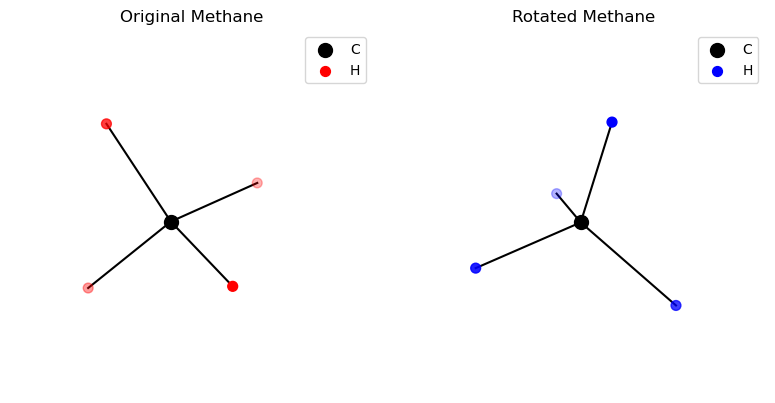

In [30]:
# Display original and rotated molecule
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(8, 4))

# Original molecule
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(mol[0, 0], mol[0, 1], mol[0, 2], c='k', s=100, label='C')
ax1.scatter(mol[1:, 0], mol[1:, 1], mol[1:, 2], c='r', s=50, label='H')
for i in range(1, 5):
    ax1.plot([mol[0, 0], mol[i, 0]], 
             [mol[0, 1], mol[i, 1]], 
             [mol[0, 2], mol[i, 2]], 'k-')
ax1.set_title('Original Methane')
ax1.legend()

# Rotated molecule
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(mol_rotated[0, 0], mol_rotated[0, 1], mol_rotated[0, 2], c='k', s=100, label='C')
ax2.scatter(mol_rotated[1:, 0], mol_rotated[1:, 1], mol_rotated[1:, 2], c='b', s=50, label='H')
for i in range(1, 5):
    ax2.plot([mol_rotated[0, 0], mol_rotated[i, 0]], 
             [mol_rotated[0, 1], mol_rotated[i, 1]], 
             [mol_rotated[0, 2], mol_rotated[i, 2]], 'k-')
ax2.set_title('Rotated Methane')
ax2.legend()

# Set equal aspect ratio
ax1.set_box_aspect((1,1,1))
ax2.set_box_aspect((1,1,1))
ax1.set_axis_off()
ax2.set_axis_off()

plt.tight_layout()
plt.show()

In [31]:
output_rotated = nn(mol_rotated, weights)
print("Rotated Output: {}".format(output_rotated))

print("Difference in output: {}".format(output - output_rotated))

Rotated Output: [ 0.00212946 -1.16574235  1.56485892 -1.47337665  1.07213063]
Difference in output: [-0.01269577 -0.96742586 -0.70166091  1.40784727  0.27393526]


As an example let's try to make a model that is invariant to rotations about the x-axis. Simply enough we just have to sum across the varying axes!

In [32]:
new_weights = np.random.randn(num_atoms)

def invariant_nn(mol, weights):
    mol_ys = np.sum(mol[:, 1])
    mol_zs = np.sum(mol[:, 2])
    out = np.dot(mol[:, 0], weights.T) + mol_ys + mol_zs
    return out

In [33]:
output_invariant = invariant_nn(mol, new_weights)
output_rotated_invariant = invariant_nn(mol_rotated, new_weights)

print("Output: {}".format(output_invariant))
print("Rotated Output: {}".format(output_rotated_invariant))
print("Difference in output: {}".format(output_invariant - output_rotated_invariant))

Output: -2.1984204625093744
Rotated Output: -2.1984204625093735
Difference in output: -8.881784197001252e-16


Nice, our model is now invariant to rotations about the x-axis, but what about the y-axis / z-axis? 
What about translations? 
What about reflections?
We can build a general model that is **invariant** to all these transformations, and we would direct the interested reader to [Ch.9 Input Data and Equivariances](https://dmol.pub/dl/data.html) for a detailed discussion on this.

# What is Equivariance?

In general equivariance is a form of symmetry for functions.
Suppose we have a set (technically, a group) of transformations $G$, mapping from domain $X$ to co-domain $Y$, we say that a function $f: X \rightarrow Y$ is equivariant to $G$ if for all $x \in X$ there exist ($g \in G$ and $g' \in G$), we have $f(gx) = g' f(x)$.

But this is really abstract, so let's break it down step-by-step.
First let's take an example, suppose we are working with 3D coordinates and $g$ just cycles the coordinates clockwise (permutation).
Then 
$$f1([x, y, z]) = [z + y, x + z, x + y]$$ 
is equivarant to $g$, because 
$$f1(g[x, y, z]) = f1([z, x, y]) = [x + y, y + z, z + x]$$
$$g' f1([x, y, z]) = g' [z + y, x + z, x + y] = [x + y, y + z, z + x]$$

where $g' = g$. (This is the same math that makes GNN layers permutationally equivariant).

In [2]:
def f(x: np.ndarray) -> np.ndarray:
    y = [x[1] + x[2], x[0] + x[2], x[0] + x[1]]
    return np.array(y)

v1 = np.array([1, 2, 3])
print(f"Vector (v1): {v1}")
permutation = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]) # Permutation matrix
print(f"Permutation matrix (g): \n{permutation}")
permuted_v1 = np.dot(permutation, v1) # Permutes the vector
print(f"Permuted vector (g*v1): {permuted_v1}")
out_permuted_f1 = f(permuted_v1)
print(f"Output on permuted vector f1(g*v1): {out_permuted_f1}")
out_f1 = f(v1)
permuted_out_f1 = np.dot(permutation, out_f1)
print(f"Output on vector g'f1(v1): {permuted_out_f1}")

Vector (v1): [1 2 3]
Permutation matrix (g): 
[[0 1 0]
 [1 0 0]
 [0 0 1]]
Permuted vector (g*v1): [2 1 3]
Output on permuted vector f1(g*v1): [4 5 3]
Output on vector g'f1(v1): [4 5 3]


That was the most general form of equivariance, however, as we discussed, we are much more interested in the symmetries of 3D Euclidean Spaces, i.e., Rotations, Translations and Inversions.